In [1]:
import torch
import os
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

class Trainer:
    def __init__(self, lr = 0.00003, batch_size = 32):
        self.lr = lr
        self.batch = batch_size
        
        # Define hparams here or load them from a config file
        
    def fit_epoch(self, model, train_loader, criterion, optimizer):
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0
  
        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) 
            processed_data += inputs.size(0)
        train_loss = running_loss / processed_data
        return train_loss
        
    def eval_epoch(self, model, val_loader, criterion):
        model.eval()
        running_loss = 0.0
        
        processed_size = 0

        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            processed_size += inputs.size(0)
        val_loss = running_loss / processed_size
        return val_loss
        
    def train(self, model, epochs, train_dataset,val_dataset,  loss_func):
        
        train_dataset = train_dataset
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataset = val_dataset
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = model
        
        criterion = loss_func
        
        optimizer = torch.optim.Adam(model.parameters(), lr = self.lr)
        self.optimizer = optimizer
        
        for epoch in range(epochs):
            train_loss = self.fit_epoch(model, train_loader, criterion, optimizer)
            print("train_loss= ", train_loss)

            val_loss = self.eval_epoch(model, val_loader, criterion)
            print("val_loss= ", val_loss, "\n")
    

cpu


In [2]:
from typing import Tuple
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch
import numpy as np
import os
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from PIL import Image

class ColorizeData(Dataset):
    def __init__(self, files):
        # Initialize dataset, you may use a second dataset for validation if required
        # Use the input transform to convert images to grayscale
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.input_transform = T.Compose([T.ToTensor(),
                                          T.Resize(size=(256,256)),
                                          T.Grayscale(),
                                          T.Normalize((0.5), (0.5))
                                          ])
        # Use this on target images(colorful ones)
        self.target_transform = T.Compose([T.ToTensor(),
                                           T.Resize(size=(256,256)),
                                           T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    def __len__(self) -> int:
        # return Length of dataset
        return len(self.files)
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    
    def __getitem__(self, index) :
        # Return the input tensor and output tensor for training
        image = self.load_sample(self.files[index])
        image_target = self.target_transform(image)
        image_grey = self.input_transform(image)
        return image_grey, image_target

In [3]:
import torch.nn as nn
import torchvision.models as models


class Net(nn.Module):
    def __init__(self, input_size=256):
        super(Net, self).__init__()
    

        # ResNet - First layer accepts grayscale images, 
        # and we take only the first few layers of ResNet for this task
        resnet = models.resnet18(num_classes=100)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        RESNET_FEATURE_SIZE = 128
        ## Upsampling Network
        self.upsample = nn.Sequential(     
          nn.Conv2d(RESNET_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):
        #print(input.size())
        midlevel_features = self.midlevel_resnet(input)
        output = self.upsample(midlevel_features)
        return output


The code in the cell below unpacks the zip file with the dataset

In [4]:
#import zipfile as zf
#files = zf.ZipFile("train_landscape_images.zip", 'r')
#files.extractall('Landscape')
#files.close()

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt



In [6]:

import os
import torchvision.transforms as T
from torchvision.io import read_image
from pathlib import Path
dirr = "Landscape/landscape_images"
img_path = os.path.join(dirr)
TRAIN_DIR = Path(img_path)
train_val_files1 = list(TRAIN_DIR.rglob('*.jpg'))

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
def load_sample(file):
    image = Image.open(file)
    image.load()
    return image

Let's check the dataset for the images which already are in grayscale:

In [9]:
for i in tqdm(range (4282)):
    if min(np.shape(load_sample(train_val_files1[i]))) != 3:
        print(i,min(np.shape(load_sample(train_val_files1[i]))) )

 86%|██████████████████████████████████████████████████████████████████▎          | 3690/4282 [00:34<00:05, 101.10it/s]

3670 1064


 93%|████████████████████████████████████████████████████████████████████████▋     | 3991/4282 [00:37<00:03, 94.60it/s]

3981 737
3994 4


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4048/4282 [00:38<00:02, 98.17it/s]

4037 800


100%|█████████████████████████████████████████████████████████████████████████████| 4282/4282 [00:40<00:00, 104.90it/s]


Since the preprocessing of the image is supposed to be for an RGB- image let's delete grayscale images

In [10]:
train_val_files = np.delete(train_val_files1, 4037)
train_val_files =np.delete(train_val_files, 3994)
train_val_files =np.delete(train_val_files, 3981)
train_val_files =np.delete(train_val_files, 3670)


Train/val split:

In [11]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.07)
train_dataset = ColorizeData(train_files)
val_dataset = ColorizeData(val_files)

Some of the pictures in datasets:

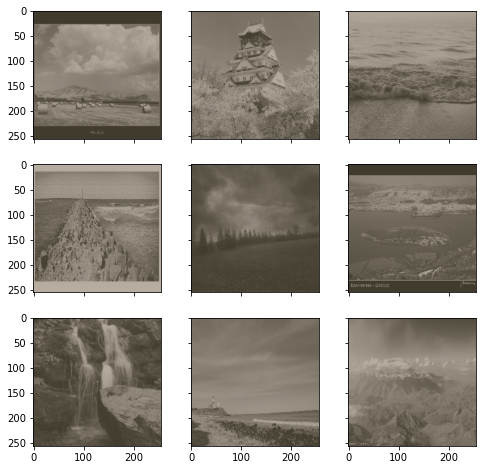

In [12]:
np.random.seed(1)
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_land = int(np.random.uniform(0,300))
    im_in, im_target = val_dataset[random_land]
    
    imshow(im_in.data.cpu(), \
          plt_ax=fig_x)

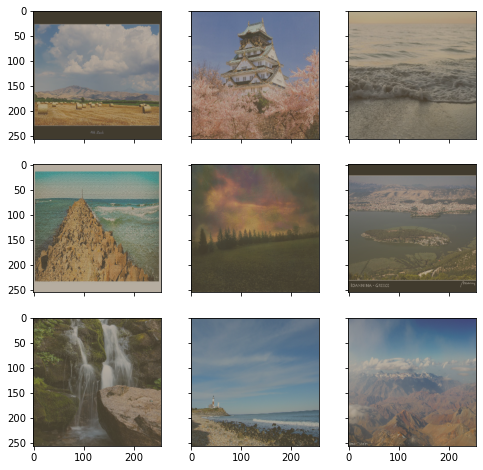

In [13]:
np.random.seed(1)
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_land = int(np.random.uniform(0,300))
    im_in, im_target = val_dataset[random_land]
    
    imshow(im_target.data.cpu(), \
          plt_ax=fig_x)

Dataloaders:

In [14]:
batch_size = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [15]:
criterion = torch.nn.MSELoss()
trainer = Trainer()
model = Net()

In [16]:
model.load_state_dict(torch.load("weights.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
trainer.train(model,  7, train_dataset, val_dataset,  criterion)

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [09:26<00:00,  4.53s/it]


train_loss=  0.05305789975199404
val_loss=  0.04830813338359197 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [09:13<00:00,  4.43s/it]


train_loss=  0.04577121223885399
val_loss=  0.045344367523988086 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:53<00:00,  4.27s/it]


train_loss=  0.04449825882705658
val_loss=  0.0448283950984478 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:39<00:00,  4.16s/it]


train_loss=  0.04400840789536665
val_loss=  0.044627781907717386 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [34:00<00:00, 16.32s/it]


train_loss=  0.04371677040997583
val_loss=  0.044531648655732475 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:58<00:00,  4.31s/it]


train_loss=  0.043509688363220896
val_loss=  0.04447258378068606 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [09:04<00:00,  4.36s/it]


train_loss=  0.0433473917517517
val_loss=  0.04443005487322807 



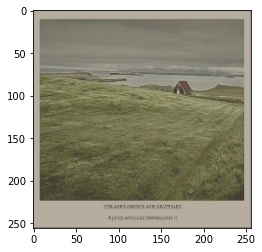

In [18]:
imshow(next(iter(train_loader))[1][0].detach().cpu())

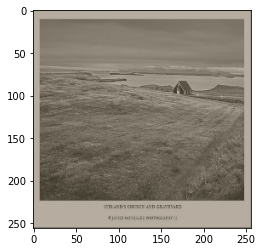

In [19]:
imshow(next(iter(train_loader))[0][0].detach().cpu())

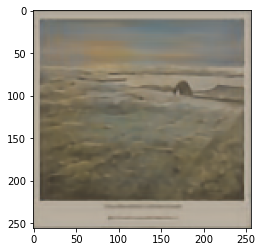

In [20]:
imshow(model(next(iter(train_loader))[0])[0].detach().cpu())

In [349]:
torch.save(model.state_dict(), "weights.pth")


    As we can see, the image above is rather blurry and has a low quality, even though the training took about 40 epochs. Let's modify the architecture by adding one other convolutional layer and a "skip-connection" from input to this layer

In [21]:
class Net2(nn.Module):
    def __init__(self, input_size=256):
        super(Net2, self).__init__()
    

        # ResNet - First layer accepts grayscale images, 
        # and we take only the first few layers of ResNet for this task
        resnet = models.resnet18(num_classes=100)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        RESNET_FEATURE_SIZE = 128
        ## Upsampling Network
        self.upsample = nn.Sequential(     
          nn.Conv2d(RESNET_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )
        self.deblur = nn.Sequential(
            nn.Conv2d(4, 3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, input):
        #print(input.size())
        midlevel_features = self.midlevel_resnet(input)
        colors = self.upsample(midlevel_features)
        output = self.deblur(torch.cat((input,colors), dim=1))
        return output


In [22]:
model2 = Net2()

In [23]:
#model2.upsample.load_state_dict(model.upsample.state_dict())

In [24]:
model2.load_state_dict(torch.load("weights2.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
trainer.train(model2,  5, train_dataset, val_dataset,  criterion)

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [10:02<00:00,  4.82s/it]


train_loss=  0.032136894539635405
val_loss=  0.030831200778484346 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [10:14<00:00,  4.92s/it]


train_loss=  0.02969813025137433
val_loss=  0.02911487005650997 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [10:48<00:00,  5.19s/it]


train_loss=  0.02869582763377178
val_loss=  0.02868451066315174 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [10:56<00:00,  5.25s/it]


train_loss=  0.02832139852934818
val_loss=  0.028531981830795607 



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [10:39<00:00,  5.12s/it]


train_loss=  0.028082344842566175
val_loss=  0.028439030175407727 



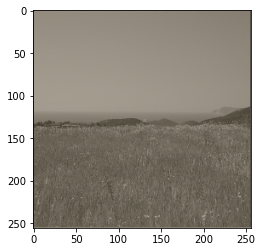

In [40]:
imshow(next(iter(val_loader))[0][15].detach().cpu())

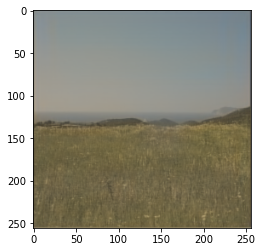

In [41]:
imshow(model2(next(iter(val_loader))[0])[15].detach().cpu())

In [35]:
torch.save(model2.state_dict(), "weights2.pth")

    As we can see, the picture above has higher quality and the problem of blurring is resolved, thus the change in architecture can be called successful. 
    In order to resolve the problem of blurring at first I tried to use different filters, such as increasing saturation with given probability and so on, however that did't prove to be useful and only worsened the situation. Then I realized that we lose quite a lot of spacial information through applying resnet layers which led me to an idea to concatenate the input with the output features of the upsample layer and apply another convolutional layer to it in order to get three-dimensional output. Thus such an idea led to a great improvement in the performance and quality.